In [1]:
import os

import chainer
from chainer import configuration
from chainer.dataset import convert
import chainer.links as L
import chainer.functions as F
from chainer import serializers

import math
import numpy as np
import cupy as cp
import random

import sklearn
from sklearn.utils import shuffle
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

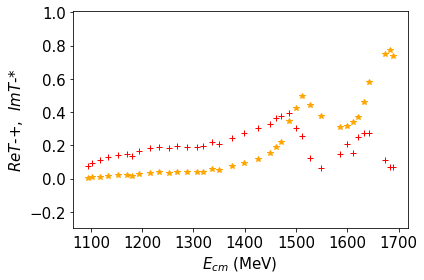

In [2]:
#SAID-GWU model
#Center-of-mass energy axis (in MeV) and the real and imaginary parts of scattering amplitude
#Data points not beyond K-Lambda threshold
piN_data = pd.read_excel("S11_piN.xlsx", 
                         sheet_name="S11-SAID", 
                         usecols=[2,7,9], 
                         skiprows=[0],
                         nrows=37)  #30-upto K-Lambda only
Einput = piN_data["Ecm"].tolist()
Treal = piN_data["Trl"].tolist()
Timag = piN_data["Tim"].tolist()

Einput = np.array(Einput)
Treal = np.array(Treal)
Timag = np.array(Timag)

#Load amplitude error
piN_data = pd.read_excel("S11_piN.xlsx", 
                         sheet_name="S11-SAID", 
                         usecols=[8,10], 
                         skiprows=[0],
                         nrows=37)  #30-upto K-Lambda only
TrealErr = piN_data["TrlErr"].tolist()
TimagErr = piN_data["TimErr"].tolist()

font_set_size = 15
plt.ylim(-0.3,1.01)
plt.plot(Einput,Treal,'+',color='red')
plt.plot(Einput,Timag,'*',color='orange')
#plt.plot(Einput,Tsqr,'o',color='blue')
plt.xlabel('$E_{cm}$ (MeV)', fontsize=font_set_size)
plt.xticks(fontsize=font_set_size)
plt.ylabel('$ReT$-+,  $ImT$-*',fontsize=font_set_size)
plt.yticks(fontsize=font_set_size)
plt.tight_layout()

#descriptive labels of network output
#at most 4 poles in all RS
labelz = [
#default no pole
    'no nearby pole',                          #00
#poles in [bt]    
    '1 pole  in [bt]',                          #01
    '2 poles in [bt]',                         #02
    '3 poles in [bt]',                         #03
    '4 poles in [bt]',                         #04
#[bt] and [bb] no shadow pair    
    '3 poles in [bt] and 1 pole  in [bb]',      #05
    '2 poles in [bt] and 1 pole  in [bb]',      #06
    '2 poles in [bt] and 2 poles in [bb]',     #07 
    '1 pole  in [bt] and 2 poles in [bb]',      #08
    '1 pole  in [bt] and 3 poles in [bb]',     #09
    '1 pole  in [bt] and 1 pole  in [bb]',      #10
#poles in [bb] only    
    '1 pole  in [bb]',                          #11
    '2 poles in [bb]',                         #12
    '3 poles in [bb]',                         #13
    '4 poles in [bb]',                         #14
#[bb] and [tb] no shadow pair    
    '3 poles in [bb] and 1 pole  in [tb]',      #15
    '2 poles in [bb] and 1 pole  in [tb]',      #16
    '2 poles in [bb] and 2 poles in [tb]',     #17   
    '1 pole  in [bb] and 2 poles in [tb]',      #18
    '1 pole  in [bb] and 3 poles in [tb]',     #19
    '1 pole  in [bb] and 1 pole  in [tb]',      #20
#poles in [tb] only    
    '1 pole  in [tb]',                          #21
    '2 poles in [tb]',                         #22
    '3 poles in [tb]',                         #23
    '4 poles in [tb]',                         #24    
#[tb] and [bt]
    '3 poles in [tb] and 1 pole  in [bt]',      #25
    '2 poles in [tb] and 1 pole  in [bt]',      #26
    '2 poles in [tb] and 2 poles in [bt]',     #27
    '1 pole  in [tb] and 2 poles in [bt]',      #28
    '1 pole  in [tb] and 3 poles in [bt]',     #29 
    '1 pole  in [tb] and 1 pole  in [bt]',      #30      
#poles in all three
    '2 poles in [bt] and 1 pole  in [bb] and 1 pole  in [tb]',    #31
    '1 pole  in [bt] and 2 poles in [bb] and 1 pole  in [tb]',    #32
    '1 pole  in [bt] and 1 pole  in [bb] and 2 poles in [tb]',    #33
    '1 pole  in [bt] and 1 pole  in [bb] and 1 pole  in [tb]'      #34
]

In [3]:
def Error(halfbar):
    error = []
    for n in range(len(halfbar)):
        errorn = np.random.uniform(low=-halfbar[n], high=+halfbar[n])
        #errorn=np.random.normal(loc=0.0, scale=halfbar[n],size=None)
        #errorn=np.random.normal(loc=0.0, scale=halfbar[n]/2.0,size=None)
        #errorn=np.random.normal(loc=0.0, scale=halfbar[n]/3.0,size=None)
        #errorn=np.random.normal(loc=0.0, scale=halfbar[n]/4.0,size=None)
        #errorn=np.random.normal(loc=0.0, scale=halfbar[n]/5.0,size=None)
        #errorn = np.random.poisson(halfbar[n])
        error.append(errorn)
    error=np.asarray(error)
    return error

In [14]:
import import_ipynb
import dnn_models
from dnn_models import MLP3L
device = 0

trainingdirectory = 'dnn_curr32_full'
training = pickle.load(open(os.path.join(trainingdirectory,"training_accu1.pkl"),"rb"))
testing = pickle.load(open(os.path.join(trainingdirectory,"testing_accu1.pkl"),"rb"))
print('We are now in epoch:', len(training))
print('You can only use DNN in multiple of 10 epoch version during the inference stage')

We are now in epoch: 31139
You can only use DNN in multiple of 10 epoch version during the inference stage


In [15]:
training[31100-1]

0.7240249701134439

In [ ]:
epochmodel = 31100 #31070
print(training[epochmodel-1])

directory = 'dnn_curr32_snapshot//epoch{:06d}'.format(epochmodel)
dnn_model = MLP3L(200,200,200)
dnn_model = L.Classifier(dnn_model)
dnn_model.to_device(device)

said_result = []

Nexpdata = 1000000
for n in range(Nexpdata):
    RealError = Error(TrealErr)
    ImagError = Error(TimagErr)
    data_n = np.concatenate((Einput,Treal-TrealErr+RealError,Timag-TimagErr+ImagError))
    data_n = cp.asarray(data_n, dtype=np.float32)
   
    serializers.load_npz(os.path.join(directory,'MLP1.model'), dnn_model)
    model = dnn_model.predictor
    
    said_result.append(int(model(data_n[None, ...])[0].array.argmax()))

0.7240249701134439


## Testing inferences on different epoch versions

In [ ]:
print('generated amplitudes from SAID data:',Nexpdata)
print('Training accuracy of DNN after {} epochs:'.format(epochmodel),
      '{:0.3f}'.format(100*training[epochmodel-1]))
print()
print('error bar = uniform distribution')
print('Results:')
for classif in range(0,35):
    counts = said_result.count(classif)
    if counts != 0:
        percent = counts/len(said_result)*100
        print('{:06.3f}% with '.format(percent),'{:>55}'.format(labelz[classif]))

In [13]:
print('generated amplitudes from SAID data:',Nexpdata)
print('Training accuracy of DNN after {} epochs:'.format(epochmodel),
      '{:0.3f}'.format(100*training[epochmodel-1]))
print()
print('error bar = uniform distribution')
print('Results:')
for classif in range(0,35):
    counts = said_result.count(classif)
    if counts != 0:
        percent = counts/len(said_result)*100
        print('{:06.3f}% with '.format(percent),'{:>55}'.format(labelz[classif]))

generated amplitudes from SAID data: 1000000
Training accuracy of DNN after 31070 epochs: 69.355

error bar = uniform distribution
Results:
99.967% with  1 pole  in [bt] and 1 pole  in [bb] and 2 poles in [tb]
00.033% with  1 pole  in [bt] and 1 pole  in [bb] and 1 pole  in [tb]
